In [85]:
import os
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np

from libs.util import ImageChunker
from libs.pconv_model import PConvUnet

# Segmentation

In [86]:
path_to_model = 'data/frozen_inference_graph_coco.pb'
path_to_config= 'data/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt'
SAMPLE_IMAGE='data/menschlaufen.jpg'
SAMPLE_MASK="data/mask.png"
ALGO_INPAINT="data/algo_inpaint.png"
MODEL_INPAINT="data/model_inpaint.png"
INPAINT_WEIGHTS="data/weights.26-1.07.h5"
original_img = cv2.imread(SAMPLE_IMAGE)
original_img = cv2.resize(original_img,(512,512))
BATCH_SIZE = 4
colors = np.random.randint(125, 255, (90, 3))
IMAGE_INPAINT = 10

In [87]:
model = cv2.dnn.readNetFromTensorflow(path_to_model,path_to_config)
img = cv2.imread(SAMPLE_IMAGE)
img = cv2.resize(img,(512,512))
height, width, _ = img.shape
black_image = np.zeros((height, width, 3), np.uint8)
black_image[:] = (0, 0, 0)

blob = cv2.dnn.blobFromImage(img, swapRB=True)
model.setInput(blob)
boxes, masks = model.forward(["detection_out_final", "detection_masks"])
detection_count = boxes.shape[2]

for i in range(detection_count):
     box = boxes[0, 0, i]
     class_id = box[1]
     score = box[2]
     if score < 0.5:
         continue
     print(class_id)
     x = int(box[3] * width)
     y = int(box[4] * height)
     x2 = int(box[5] * width)
     y2 = int(box[6] * height)
     roi = black_image[y: y2, x: x2]
     roi_height, roi_width, _ = roi.shape
     mask = masks[i, int(class_id)]
     mask = cv2.resize(mask, (roi_width, roi_height))
     _, mask = cv2.threshold(mask, 0.5, 255, cv2.THRESH_BINARY)
     cv2.rectangle(img, (x, y), (x2, y2), (255, 0, 0), 3)
     contours, _ = cv2.findContours(np.array(mask, np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
     color = colors[int(class_id)]
     for cnt in contours:
         cv2.fillPoly(roi, [cnt], (int(color[0]), int(color[1]), int(color[2])))

cv2.imwrite('data/output.png', np.hstack([img,black_image]))
cv2.imwrite('data/Overlay_image.png', ((0.6*black_image)+(0.4*img)).astype("uint8"))

0.0


True

# Mask Correction

In [88]:
onebite_masc = cv2.cvtColor(black_image, cv2.COLOR_BGR2GRAY)


True

In [89]:
onebite_masc = cv2.cvtColor(black_image, cv2.COLOR_BGR2GRAY)

img_pre_output = original_img.copy()

j = 0
for row in img_pre_output:
    i = 0
    for element in row:
        if (onebite_masc[j, i] != 0):
            row[i] = [255, 255, 255]
        i = i + 1
    # print(row)
    j = j + 1

img_output = original_img.copy()

j = 0
for row in img_pre_output:
    i = 0
    for element in row:
        if np.array_equal(element, [255, 255, 255]):
                img_output = cv2.circle(img_output, (i, j), IMAGE_INPAINT, (255, 255, 255), 0)
        i = i + 1
    j = j + 1

mask_output = img_output.copy()

j = 0
for row in mask_output:
    i = 0
    for element in row:
        if not np.array_equal(element, [255, 255, 255]):
            row[i] = [0, 0, 0]
        i = i + 1
    # print(row)
    j = j + 1

In [90]:
print(mask_output)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [91]:
final_onebite_masc = cv2.cvtColor(mask_output, cv2.COLOR_BGR2GRAY)
cv2.imwrite("data/mask_out_workbook.png", mask_output)
cv2.imwrite(SAMPLE_MASK, final_onebite_masc)
dst = cv2.inpaint(original_img,final_onebite_masc,3,cv2.INPAINT_TELEA)
output_mask_img = cv2.add(original_img,mask_output)
cv2.imwrite(ALGO_INPAINT, dst)
cv2.imwrite('data/output_mask_img.png', output_mask_img )

True

# Inpainting

In [92]:
model = PConvUnet(vgg_weights=None, inference_only=True)
model.load(INPAINT_WEIGHTS, train_bn=False)

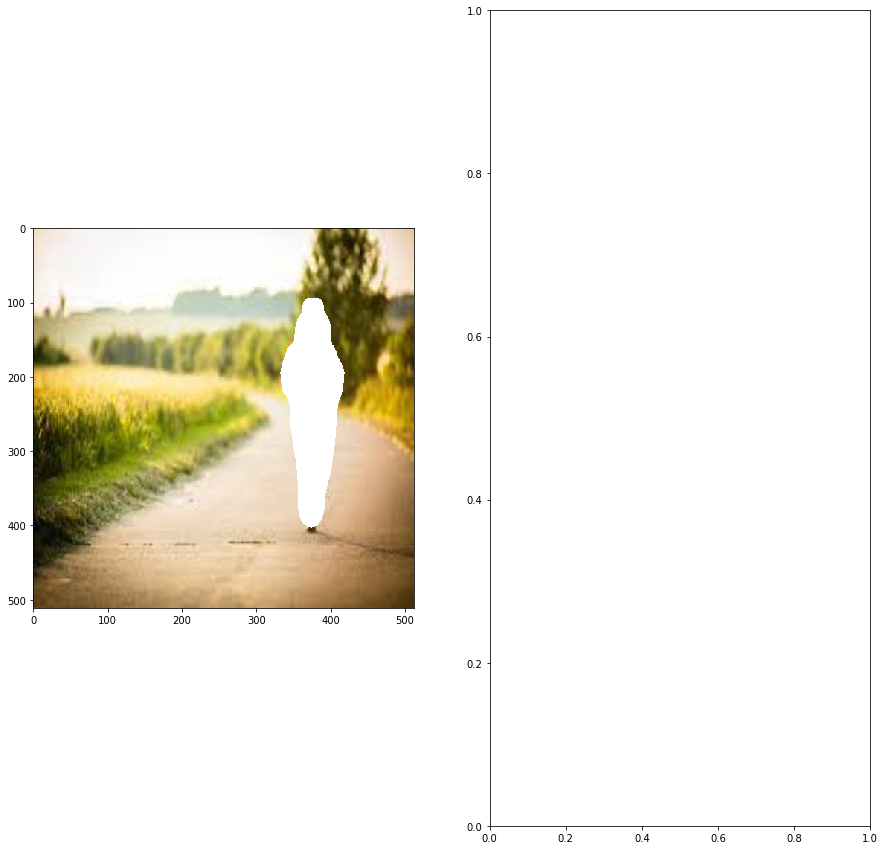

In [93]:
im = output_mask_img.copy() / 255
buffer = im.copy()

im[:, :, 2] = im[:, :, 0]
im[:, :, 0] = buffer[:, :, 2]

mask = Image.open(SAMPLE_MASK).resize((512, 512)).convert('RGB')

mask = np.array(mask)
mask[mask!=0] = 2
mask[mask==0] = 1
mask[mask==2] = 0
im[mask==0] = 1


imgs, masks = [], []

imgs.append(np.asarray(im))
masks.append(np.asarray(mask))

_, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(im)


<class 'numpy.ndarray'>
(512, 512, 3)


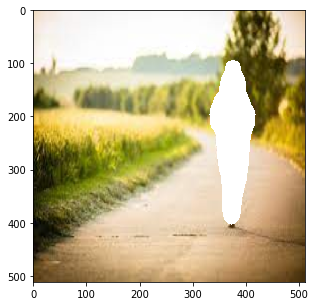

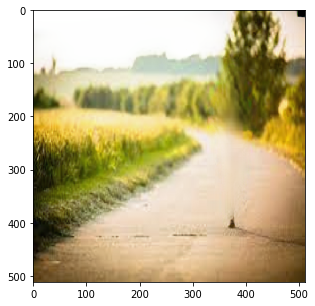

In [94]:
chunker = ImageChunker(512, 512, 30)
print(type(im))
print(im.shape)
def plot_images(images, s=5):
    _, axes = plt.subplots(1, len(images), figsize=(s*len(images), s))
    if len(images) == 1:
        axes = [axes]
    for img, ax in zip(images, axes):
        ax.imshow(img)
    plt.show()

# Process sample
chunked_images = chunker.dimension_preprocess(deepcopy(im))
chunked_masks = chunker.dimension_preprocess(deepcopy(mask))
pred_imgs = model.predict([chunked_images, chunked_masks])
reconstructed_image = chunker.dimension_postprocess(pred_imgs, img)

cv2.imwrite('data/final.png', pred_imgs[0] )


# Plot results
plot_images(chunked_images)
plot_images(pred_imgs)

In [95]:
pred_imgs.shape

(1, 512, 512, 3)

In [96]:
cv2.imwrite('./data/output_mask_img.png', cv2.cvtColor(pred_imgs[0] * 255 , cv2.COLOR_BGR2RGB))

True